In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import gc
import math
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras.backend as K

import cv2

import open3d as o3

from functools import partial

from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
clip180 = partial(np.clip, a_min=-3.14, a_max=3.14)
clip90 = partial(np.clip, a_min=0., a_max=1.57)

In [4]:
def show_pcd_3d(x_data, save=False, name=None):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')


def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [5]:
def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

In [6]:
def q_norm(q):
    return np.sum(np.square(q))


def q_inv(q):
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / q_norm(q)
    return invq


def q_mut(q1, q2):
    assert len(q1) == 4 == len(q2)
    a1, b1, c1, d1 = q1
    a2, b2, c2, d2 = q2
    
    qw = (a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2)
    qx = (a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2)
    qy = (a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2)
    qz = (a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2)
    
    return np.array([qw, qx, qy, qz])


def rotate_with_q(xyz, q):
    xyz_tmp = np.append(xyz, 0)
    q_tmp = q_mut(q, q_mut(xyz_tmp, q_inv(q)))
    return q_tmp[:3]

In [7]:
def z_norm(x, max_x, min_x):
    norm = (x - min_x) / (max_x - min_x)
    return np.float32(norm)

In [8]:
def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

In [9]:
def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

In [10]:
os.listdir("data_generator/datasets/feature_map/dev_data")

['bunny_test_8000.txt',
 'normal_socket_test_1.txt',
 'normal_socket_test_5.txt',
 'normal_socket_test_600.txt',
 'Readme.md']

In [11]:
os.listdir("data_generator/datasets/feature_map/train_data")

['bunny_train_30000.txt',
 'normal_socket_test_9000.txt',
 'normal_socket_train_1.txt',
 'normal_socket_train_10.txt',
 'normal_socket_train_1000.txt',
 'normal_socket_train_200.txt',
 'normal_socket_train_30000.txt',
 'normal_socket_whple_train_1000.txt',
 'normal_socket_whple_train_200.txt',
 'ori_test.txt',
 'Readme.md']

In [6]:
# for training parts
x_train = np.loadtxt("data_generator/datasets/feature_map/train_data/ori_partial_pcd20000.txt")
y_train = np.loadtxt("data_generator/datasets/feature_map/train_data/ro_partial_pcd20000.txt")
whole_pcd = np.loadtxt("data_generator/datasets/feature_map/train_data/whole_pcd.txt")

In [7]:
# for dev parts
x_dev = np.loadtxt("data_generator/datasets/feature_map/dev_data/fori_partial_pcd5000.txt")
y_dev = np.loadtxt("data_generator/datasets/feature_map/dev_data/rof_partial_pcd5000.txt")



In [8]:
x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, whole_pcd.shape

((20000, 1500), (20000, 1500), (5000, 1500), (5000, 1500), (2854, 3))

Text(0.5, 0.92, 'original')

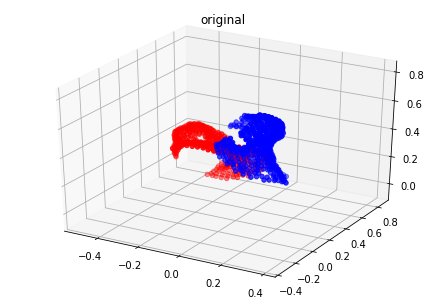

In [85]:
fig = plt.figure()
ax = Axes3D(fig)

ori_pcd = x_train[5]

ori_x = ori_pcd[:, 0]
ori_y = ori_pcd[:, 1]
ori_z = ori_pcd[:, 2]

ax.scatter(ori_x, ori_y, ori_z, c='r', marker='o')

ro_pcd = y_train[5]

ro_x = ro_pcd[:, 0]
ro_y = ro_pcd[:, 1]
ro_z = ro_pcd[:, 2]

ax.scatter(ro_x, ro_y, ro_z, c='b', marker='o')
ax.set_title('original')



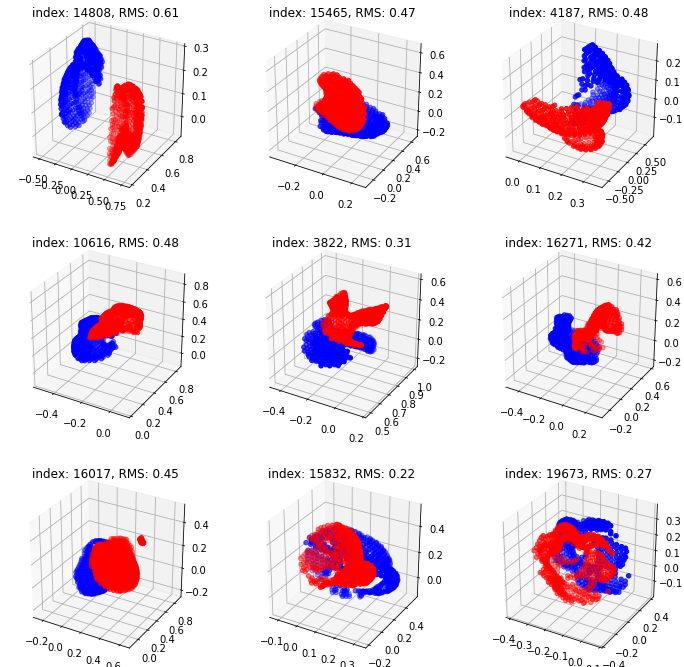

In [89]:
show_match_result(x_train, y_train)

In [9]:
x_train = x_train.reshape(20000, 500, 3)
y_train = y_train.reshape(20000, 500, 3)
x_dev = x_dev.reshape(5000, 500, 3)
y_dev = y_dev.reshape(5000, 500, 3)

In [10]:
x_train /= np.max(x_train)
y_train /= np.max(y_train)

x_dev /= np.max(x_dev)
y_dev /= np.max(y_dev)

whole_pcd /= np.max(whole_pcd)


In [11]:
x_train_whole_pcd = []
y_train_whole_pcd = []

for i in range(20000):
    for i in range(whole_pcd.shape[0]):
        x_train_whole_pcd.append(whole_pcd[i])


In [12]:
test_x = np.asarray(x_train_whole_pcd)

In [13]:
test_x = test_x.reshape(20000,2854,3)

In [14]:
test_x.shape

(20000, 2854, 3)

In [46]:
test_dev_x = test_x[:5000]
print(test_dev_x.shape)

(5000, 2854, 3)


In [15]:
np.max(x_train), np.max(y_train), np.max(x_dev), np.max(y_dev), np.min(x_train), np.min(y_train), np.min(x_dev), np.min(y_dev) 

(1.0,
 1.0,
 1.0,
 1.0,
 -0.5067766483848796,
 -0.9304564266099885,
 -0.5067766483848796,
 -0.930560424964001)

In [183]:
def cnn_model(input_shape1=(500, 3), input_shape2=(2854, 3)):
    input1 = Input(shape=input_shape1)
    input2 = Input(shape=input_shape2)

    # Ori PCD Input
    Ori_C1 = Conv1D(32, 5, padding='same', name='ori_conv1d_1')(input1)
    Ori_C1 = BatchNormalization(name='ori_batch_normalization_c1')(Ori_C1)
    Ori_C11 = Activation('relu')(Ori_C1)
    
    Ori_C2 = Conv1D(32, 5, padding='same', name='ori_conv1d_2')(Ori_C11)
    Ori_C2 = BatchNormalization(name='ori_batch_normalization_c2')(Ori_C1)
    Ori_C12 = Activation('relu')(Ori_C1)    
    Ori_Concat1 = concatenate([Ori_C11, Ori_C12], axis=1)

    Ori_Concat1 = Conv1D(16, 5, padding='same', name='ori_conv1d_1x1_1')(Ori_Concat1)
    
    # Whole PCD Input
    Whloe_C2 = Conv1D(32, 5, padding='same', name='conv1d_2')(input2)
    Whloe_C2 = BatchNormalization(name='batch_normalization_c2')(Whloe_C2)    
    Whloe_C12 = Activation('relu')(Whloe_C2)   

    
    Concat1 = concatenate([Ori_C11, Whloe_C12], axis=1)
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    Concat1 = Conv1D(16, 5, padding='same', name='conv1d_1x1_1')(Concat1)

    C3 = Conv1D(64, 5, padding='same', name='conv1d_3', kernel_initializer='glorot_normal')(Concat1)
    C3 = BatchNormalization(name='batch_normalization_c3')(C3)
    C21 = Activation('relu')(C3)   
    
    # 接起來 壓扁
    Concat2 = concatenate([Concat1, C21])
    Concat2 = Conv1D(32, 1, padding='same', name='conv3d_1x1_2', kernel_initializer='glorot_normal')(Concat2)
    
    C4 = MaxPooling1D(2, 2)(Concat2)
    
    # Global Average pooling3D 現在默認都用這個，原因自己查。
    C = GlobalAveragePooling1D(name='G_ave_pol')(C4)                         
    # C = Flatten()(C2)
    
    FC5 = Dense(1500, activation='relu', name='dense_1')(C)
    FC5 = BatchNormalization(name='batch_normalization_d1')(FC5)
    FC5 = Activation('relu')(FC5)
    # FC5 = Dropout(0.15)(FC5)
    
    Output = Reshape((500, 3))(FC5)
        
    model = Model(inputs=[input1, input2], outputs=Output)
    
    return model

In [184]:
model = cnn_model()

In [185]:
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 500, 3)       0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           (None, 2854, 3)      0                                            
__________________________________________________________________________________________________
ori_conv1d_1 (Conv1D)           (None, 500, 32)      512         input_43[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2854, 32)     512         input_44[0][0]                   
___________________________________________________________________________________________

In [186]:
model_checkpoint = ModelCheckpoint(f'callback_model.h5',verbose=1, monitor='val_mean_absolute_error',  mode='auto',save_best_only=True)

In [187]:
reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.5 ,patience=4, min_lr=1e-6, verbose=True)

In [188]:
# model.compile(optimizer=Adam(3e-4, decay=3e-5, amsgrad=True, clipnorm=1.), loss='mse', metrics=['accuracy', 'mse', 'mae']) 
model.compile(optimizer=SGD(3e-3, decay= 1e-7, momentum=0.9, nesterov=True), loss='mae', metrics=['accuracy', 'mse', 'mae']) 
# model.compile(optimizer=Adadelta(), loss='mse', metrics=['accuracy', 'mse', 'mae'])

In [ ]:
%%time
## without validation
# history = model.fit(x = [x_train, test_x], y = y_train, batch_size = 20, epochs=10, verbose=1,
#                     callbacks=[reduce_lr, model_checkpoint])

## with validation
history = model.fit(x = [x_train, test_x], y = y_train, batch_size = 512, epochs=200, verbose=1,
                    callbacks=[reduce_lr, model_checkpoint], validation_data =([x_dev, test_dev_x], y_dev) )


Train on 20000 samples, validate on 5000 samples
Epoch 1/200
20000/20000 [==============================] - 19s 932us/step - loss: 0.2810 - accuracy: 0.3590 - mse: 0.1203 - mae: 0.2810 - val_loss: 0.2788 - val_accuracy: 0.3700 - val_mse: 0.1161 - val_mae: 0.2788


C:\Users\dreamer\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: val_loss,val_accuracy,val_mse,val_mae,loss,accuracy,mse,mae,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
C:\Users\dreamer\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:707: RuntimeWarning: Can save best model only with val_mean_absolute_error available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/200
20000/20000 [==============================] - 17s 865us/step - loss: 0.2751 - accuracy: 0.3690 - mse: 0.1149 - mae: 0.2751 - val_loss: 0.2783 - val_accuracy: 0.3656 - val_mse: 0.1158 - val_mae: 0.2783
Epoch 3/200
20000/20000 [==============================] - 17s 874us/step - loss: 0.2729 - accuracy: 0.3735 - mse: 0.1130 - mae: 0.2729 - val_loss: 0.2778 - val_accuracy: 0.3618 - val_mse: 0.1155 - val_mae: 0.2778
Epoch 4/200
20000/20000 [==============================] - 18s 885us/step - loss: 0.2718 - accuracy: 0.3764 - mse: 0.1121 - mae: 0.2718 - val_loss: 0.2773 - val_accuracy: 0.3595 - val_mse: 0.1152 - val_mae: 0.2773
Epoch 5/200
20000/20000 [==============================] - 17s 856us/step - loss: 0.2711 - accuracy: 0.3789 - mse: 0.1115 - mae: 0.2711 - val_loss: 0.2769 - val_accuracy: 0.3602 - val_mse: 0.1150 - val_mae: 0.2769
Epoch 6/200
20000/20000 [==============================] - 17s 859us/step - loss: 0.2705 - accuracy: 0.3812 - mse: 0.1110 - mae: 0.2705 - val_lo

20000/20000 [==============================] - 17s 860us/step - loss: 0.2580 - accuracy: 0.4246 - mse: 0.1012 - mae: 0.2580 - val_loss: 0.2569 - val_accuracy: 0.4447 - val_mse: 0.1000 - val_mae: 0.2569
Epoch 41/200
20000/20000 [==============================] - 18s 878us/step - loss: 0.2578 - accuracy: 0.4250 - mse: 0.1010 - mae: 0.2578 - val_loss: 0.2565 - val_accuracy: 0.4453 - val_mse: 0.0997 - val_mae: 0.2565
Epoch 42/200
20000/20000 [==============================] - 17s 867us/step - loss: 0.2576 - accuracy: 0.4256 - mse: 0.1009 - mae: 0.2576 - val_loss: 0.2566 - val_accuracy: 0.4456 - val_mse: 0.0997 - val_mae: 0.2566
Epoch 43/200
20000/20000 [==============================] - 17s 856us/step - loss: 0.2574 - accuracy: 0.4262 - mse: 0.1007 - mae: 0.2574 - val_loss: 0.2563 - val_accuracy: 0.4457 - val_mse: 0.0995 - val_mae: 0.2563
Epoch 44/200
20000/20000 [==============================] - 17s 856us/step - loss: 0.2572 - accuracy: 0.4268 - mse: 0.1005 - mae: 0.2572 - val_loss: 0.25

20000/20000 [==============================] - 17s 853us/step - loss: 0.2537 - accuracy: 0.4336 - mse: 0.0979 - mae: 0.2537 - val_loss: 0.2536 - val_accuracy: 0.4429 - val_mse: 0.0980 - val_mae: 0.2536
Epoch 79/200
20000/20000 [==============================] - 17s 852us/step - loss: 0.2537 - accuracy: 0.4337 - mse: 0.0979 - mae: 0.2537 - val_loss: 0.2536 - val_accuracy: 0.4430 - val_mse: 0.0979 - val_mae: 0.2536
Epoch 80/200
20000/20000 [==============================] - 17s 852us/step - loss: 0.2537 - accuracy: 0.4335 - mse: 0.0979 - mae: 0.2537 - val_loss: 0.2536 - val_accuracy: 0.4425 - val_mse: 0.0979 - val_mae: 0.2536
Epoch 81/200
20000/20000 [==============================] - 17s 853us/step - loss: 0.2536 - accuracy: 0.4339 - mse: 0.0978 - mae: 0.2536 - val_loss: 0.2537 - val_accuracy: 0.4422 - val_mse: 0.0979 - val_mae: 0.2537
Epoch 82/200
20000/20000 [==============================] - 17s 852us/step - loss: 0.2535 - accuracy: 0.4340 - mse: 0.0978 - mae: 0.2535 - val_loss: 0.25

20000/20000 [==============================] - 17s 853us/step - loss: 0.2523 - accuracy: 0.4395 - mse: 0.0970 - mae: 0.2523 - val_loss: 0.2521 - val_accuracy: 0.4448 - val_mse: 0.0971 - val_mae: 0.2521
Epoch 117/200
20000/20000 [==============================] - 17s 852us/step - loss: 0.2522 - accuracy: 0.4396 - mse: 0.0970 - mae: 0.2522 - val_loss: 0.2520 - val_accuracy: 0.4448 - val_mse: 0.0970 - val_mae: 0.2520
Epoch 118/200
20000/20000 [==============================] - 17s 853us/step - loss: 0.2522 - accuracy: 0.4395 - mse: 0.0970 - mae: 0.2522 - val_loss: 0.2520 - val_accuracy: 0.4452 - val_mse: 0.0969 - val_mae: 0.2520
Epoch 119/200
20000/20000 [==============================] - 17s 853us/step - loss: 0.2521 - accuracy: 0.4397 - mse: 0.0969 - mae: 0.2521 - val_loss: 0.2520 - val_accuracy: 0.4444 - val_mse: 0.0969 - val_mae: 0.2520
Epoch 120/200
20000/20000 [==============================] - 17s 853us/step - loss: 0.2521 - accuracy: 0.4400 - mse: 0.0969 - mae: 0.2521 - val_loss: 

Epoch 154/200
20000/20000 [==============================] - 17s 868us/step - loss: 0.2508 - accuracy: 0.4469 - mse: 0.0961 - mae: 0.2508 - val_loss: 0.2508 - val_accuracy: 0.4502 - val_mse: 0.0961 - val_mae: 0.2508
Epoch 155/200
14336/20000 [====================>.........] - ETA: 4s - loss: 0.2503 - accuracy: 0.4459 - mse: 0.0957 - mae: 0.2503

In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')

In [ ]:
model.save(f'models/bunny_model.h5')

In [ ]:
model = load_model(f'models/bunny_model.h5')

In [ ]:
result = model.evaluate([x_train[:1000], test_x[:1000]], y_train[:1000])
print('Accuracy of training Set:',result[1])
print('Loss of training set:', result[0])
print()

result_dev = model.evaluate([x_dev[:1000], test_x[:1000]], y_dev[:1000])
print('Accuracy of training Set', result_dev[1])
print('Accuracy of training Set', result_dev[0])
print()



In [ ]:
result, result_dev

In [ ]:
if not os.path.exists('results'):
    os.makedirs('results')

In [ ]:
plt.plot(history.history['loss'], color = 'blue', label = 'loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'val_loss')

plt.legend(loc="best")
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.savefig(f'results/bunny_loss.png')
plt.show()

In [ ]:
start_time = datetime.datetime.now()
pred = model.predict([x_dev, test_dev_x])
end_tim = datetime.datetime.now()

In [ ]:
pred.shape

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

result_pcd = pred[5]

result_x = result_pcd[:, 0]
result_y = result_pcd[:, 1]
result_z = result_pcd[:, 2]

ax.scatter(result_x, result_y, result_z, c='r', marker='o')
ax.set_title('original')


